# TwitterStock

In [1]:
#Veriyi okuma ve işleme adımında kullanılacak kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

#Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

#Warningleri Kapatmak İçin
import warnings
warnings.filterwarnings('ignore')

#TensorFlow Warningleri Engelleme
import os
os.environ['TF_CPP_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 088F-1ED4

 Directory of C:\Users\EREN\Documents\YapayZeka\GitHub\21Project\TwitterStock

01/04/2024  08:52 PM    <DIR>          .
01/04/2024  08:52 PM    <DIR>          ..
01/04/2024  08:50 PM    <DIR>          .ipynb_checkpoints
11/05/2022  09:29 AM           158,091 TWTR.csv
12/20/2023  10:09 PM            46,026 TWTR.csv.zip
01/04/2024  08:52 PM               589 Untitled.ipynb
               3 File(s)        204,706 bytes
               3 Dir(s)  59,416,797,184 bytes free


In [44]:
df = pd.read_csv("TWTR.csv")

In [45]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701670.0
1,2013-11-08,45.930000,46.939999,40.685001,41.650002,41.650002,27925307.0
2,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113941.0
3,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316755.0
4,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688325.0


In [46]:
print("################ Shape ###################")
print(df.shape)
print("################ Types ###################")
print(df.dtypes)
print("################ Head ###################")
print(df.head())
print("################ Tail ###################")
print(df.tail())
print("################ Na ###################")
print(df.isnull().sum())
print("################ Quantiles ###################")
print(df.quantile([0,0.05,0.50,0.95,0.99,1]).T)

################ Shape ###################
(2264, 7)
################ Types ###################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object
################ Head ###################
         Date       Open       High        Low      Close  Adj Close  \
0  2013-11-07  45.099998  50.090000  44.000000  44.900002  44.900002   
1  2013-11-08  45.930000  46.939999  40.685001  41.650002  41.650002   
2  2013-11-11  40.500000  43.000000  39.400002  42.900002  42.900002   
3  2013-11-12  43.660000  43.779999  41.830002  41.900002  41.900002   
4  2013-11-13  41.029999  42.869999  40.759998  42.599998  42.599998   

        Volume  
0  117701670.0  
1   27925307.0  
2   16113941.0  
3    6316755.0  
4    8688325.0  
################ Tail ###################
            Date  Open  High  Low  Close  Adj Close  Volume
2259  2022-10-28   NaN   NaN  NaN    NaN        NaN     NaN
2260

In [47]:
df["Date"]=pd.to_datetime(df["Date"])

In [48]:
tw_df = df[["Date","Close"]]

In [49]:
tw_df.index = tw_df["Date"]

In [50]:
tw_df.drop("Date",axis=1,inplace=True)

In [51]:
result_df = tw_df.copy()

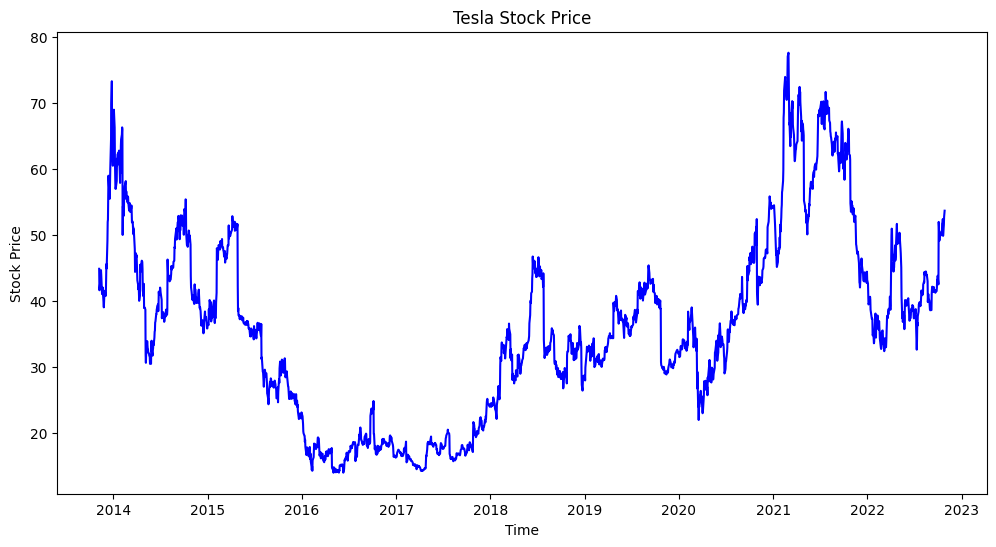

In [52]:
plt.figure(figsize=(12,6))
plt.plot(tw_df['Close'],color='blue');
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()


In [53]:
tw_df = tw_df.values

In [54]:
tw_df = tw_df.astype('float32')

In [55]:
position = int(round(len(tw_df)*(1-0.2)))
train = tw_df[:position]
test = tw_df[position:]

In [56]:
print(train.shape,test.shape)

(1811, 1) (453, 1)


In [57]:
scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)

In [58]:
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [59]:
def create_features(data,lookback):
    X,Y =[] ,[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

In [60]:
lookback = 10
#Train Veri Seti
X_train , y_train = create_features(train , lookback)
print(X_train.shape,y_train.shape)

(1801, 10) (1801,)


In [61]:
#Test Veri Seti
X_test , y_test = create_features(test , lookback)
print(X_test.shape,y_test.shape)

(443, 10) (443,)


In [62]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [63]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1801, 1, 10) (1801, 1) (443, 1, 10) (443, 1)


In [64]:
model = Sequential()

model.add(LSTM(units=50,
                   activation='relu',
                   input_shape=(X_train.shape[1],lookback)))

model.add(Dropout(0.05))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                12200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
model.compile(loss='mean_squared_error',optimizer='adam')

callbacks = [EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
             ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
                             save_best_only=True,save_weights_only=False,verbose=1)]


history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test,y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
1784/1801 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 1: val_loss did not improve from inf
1801/1801 [==============================] - 6s 3ms/step - loss: 0.0053 - val_loss: nan
Epoch 2/50
1781/1801 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 2: val_loss did not improve from inf
1801/1801 [==============================] - 5s 3ms/step - loss: 0.0019 - val_loss: nan
Epoch 3/50
1796/1801 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 3: val_loss did not improve from inf
1801/1801 [==============================] - 4s 2ms/step - loss: 0.0020 - val_loss: nan
Epoch 3: early stopping


Text(0.5, 1.0, 'Training and Validation Loss')

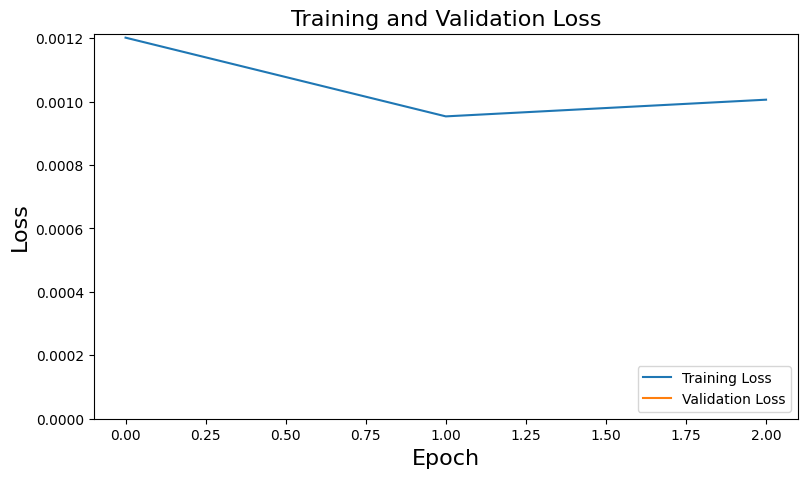

In [37]:
#------------------------
#Loss Grafik
#------------------------
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss',fontsize=16)

In [38]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print("\nTest loss: %.1f%%"%(100.0*loss))

443/443 [==============================] - 1s 1ms/step - loss: nan

Test loss: nan%


In [39]:
train_predict = model.predict(X_train)

57/57 [==============================] - 1s 1ms/step


In [40]:
test_predict = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [41]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [42]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [43]:
#Train Veri Seti ait RMSE Değeri
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))
#Test Veri Seti ait RMSE Değeri
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

ValueError: Input contains NaN.